<a href="https://colab.research.google.com/github/KOO-96/DNA_seminar/blob/main/DNA_ComputerVisionSeminar_Weeks4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weeks4
1. Pytorch, GoogLeNet
- Pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 현재 경로를 앞으로 진행할 프로젝트 디렉토리로 이동한다.
%cd /content/drive/MyDrive/CV_seminar_project 

/content/drive/MyDrive/CV_seminar_project


In [3]:
# 현재 경로 확인.
%pwd

'/content/drive/MyDrive/CV_seminar_project'

In [4]:
import torch
import torchvision
from torchvision import transforms   # 이미지 데이터 argmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [5]:
device

'cuda'

In [6]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
valid_path = '/content/drive/MyDrive/CV_seminar_project/valid'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

dolphin_dir = '/dolphin'
shark_dir = '/shark'
whale_dir = '/whale'

## pytorch 데이터 셋 클래스 실습.

> 파이토치 데이터 셋 직접 만들기
1. __init__ 생성자가 필요함.
2. __get__  -> 데이터를 읽는 역할. (index 부여, iterable)
3. __len__  -> 데이터 개수를 알려주는 역할.

In [7]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms): # 생성자 특수 메소드
    self.all_data = sorted(glob.glob(os.path.join(root_path, mode, '*', '*')))  # 데이터 경로
    self.transform = transforms  # augmentation

  def __getitem__(self, index):
    if torch.is_tensor(index):    # 인덱스가 tensor 형태임을 방지함.
      index = index.tolist()

    # 이미지 읽기
    data_path = self.all_data[index]  # 인덱스가 부여된 1개의 데이터.
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2라이브러리 : 채널 축: BGR -> RGB

    # transform (Augmentation) 적용
    if self.transform is not None:
      augmentation = self.transform(image = image)
      image = augmentation['image']
    
    # label 생성하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label
    
  def __len__(self):
    length = len(self.all_data)  # 전체 데이터 개수
    return length

> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> ToTensorV2(): 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.

In [8]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

### library 이용.
이미지 전처리
1. resize -> 224,224 (H,W)  -> vggnet기준
2. tensor화 하기 -> 픽셀 값 0~1로 바꾸기 

In [9]:
preprop_imgs = transforms.Compose(
    [ transforms.Resize( (224,224) ),
     transforms.ToTensor()
     ]
)

preprop_train = torchvision.datasets.ImageFolder(root = train_path, transform = preprop_imgs)
preprop_test = torchvision.datasets.ImageFolder(root = test_path, transform = preprop_imgs)

In [10]:
preprop_train[0][0].shape   # C, H, W   channel은 pytorch에서 맨 앞으로 감.

torch.Size([3, 224, 224])

In [11]:
preprop_train[-1][1]  # 0 -> dolphin  1 -> shark  2 -> whale

2

### image Augmentatin -1
> Normalize = (x - mean) / std  -> 여러 개가 가능함.
> 1. imageNet의 데이터 셋의 Mean과 std를 이용함.
> 2. 지금 내가 가진 데이터 셋의 통계값을 이용함.

In [12]:
Aug_imgs = transforms.Compose(
    [ transforms.Resize( (224,224) ),
     #transforms.RandomCrop(180), # 이미지를 랜덤한 일정 부분을 잘라냄.
     transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
     transforms.RandomHorizontalFlip(p = 0.5), # 이미지 좌우 반전
     transforms.RandomVerticalFlip(p = 0.5), # 이미지 상하 반전
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406],
                          std = [0.229, 0.224, 0.225])
     ]
)

Aug_train = torchvision.datasets.ImageFolder(root = train_path, transform = preprop_imgs) # augmentation 진행
Aug_test = torchvision.datasets.ImageFolder(root = test_path, transform = preprop_imgs)  # test셋은 augmentation에는 하지 않음.

In [13]:
Aug_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0078]],

        [[0.3098, 0.3098, 0.3098,  ..., 0.3255, 0.3216, 0.3216],
         [0.3098, 0.3098, 0.3098,  ..., 0.3255, 0.3216, 0.3216],
         [0.3098, 0.3098, 0.3098,  ..., 0.3255, 0.3216, 0.3216],
         ...,
         [0.3804, 0.3804, 0.3804,  ..., 0.4706, 0.4667, 0.4667],
         [0.3804, 0.3804, 0.3804,  ..., 0.4784, 0.4784, 0.4784],
         [0.3804, 0.3804, 0.3804,  ..., 0.4824, 0.4863, 0.4863]],

        [[0.6039, 0.6039, 0.6039,  ..., 0.5765, 0.5686, 0.5686],
         [0.6039, 0.6039, 0.6039,  ..., 0.5765, 0.5686, 0.5686],
         [0.6039, 0.6039, 0.6039,  ..., 0.5765, 0.5686, 0.

In [16]:
train_loader = torch.utils.data.DataLoader(Aug_train, batch_size = 4, shuffle = True,
                                      num_workers=0)

test_loader = torch.utils.data.DataLoader(Aug_test, batch_size = 4, shuffle = True,
                                      num_workers=0)

In [17]:
for data, label in train_loader:
  # output = model(data, label)
  # loss = func(output)
  # loss.backward
  break
  
data.shape # [4, 3, 224, 224] -> B C H W

torch.Size([4, 3, 224, 224])

augmentation Tool  albumentations 이용하기

In [18]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transform = None): # 생성자 특수 메소드
    self.all_data = sorted(glob.glob(os.path.join(root_path, mode, '*', '*')))  # 데이터 경로
    self.transform = transform  # augmentation

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()

    # 이미지 읽기
    data_path = self.all_data[index]
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 채널 축: BGR -> RGB

    # transform (Augmentation)
    if self.transform is not None:
      augmentation = self.transform(image = image)
      image = augmentation['image']
    
    # label 생성하기
    label = []
    if 'dolphin' in data_path.split('/')[-1]:
      label = 0
    elif 'shark' in data_path.split('/')[-1]:
      label = 1
    else:
      label = 2

    return image, label
    
  def __len__(self):
    length = len(self.all_data)  # 전체 데이터 개수
    return length

In [19]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
valid_path = '/content/drive/MyDrive/CV_seminar_project/valid'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

dolphin_dir = '/dolphin'
shark_dir = '/shark'
whale_dir = '/whale'

from PIL import Image as PILImage

pytorch_dataset = Custom_dataset(root_path = root_path, mode = 'train', transform = None)

In [20]:
import albumentations
import albumentations.pytorch

albumentations = albumentations.Compose([
    albumentations.Resize(224, 224),
    # 뒤집기 or 돌리기
    albumentations.OneOf([
        albumentations.HorizontalFlip(p = 0.8),
        albumentations.VerticalFlip(p = 0.8),
        albumentations.RandomRotate90(p = 0.8),
    ], p = 1),

    # 픽셀 장난
    albumentations.OneOf([
        albumentations.MotionBlur(p = 0.8),   # 흐리게
        albumentations.OpticalDistortion(p = 0.8),  # 왜곡
        albumentations.GaussNoise(p = 0.8)  # 노이즈 추가
    ], p = 1)
])

pytorch_dataset = Custom_dataset(root_path = root_path, mode = 'train', transform = albumentations)

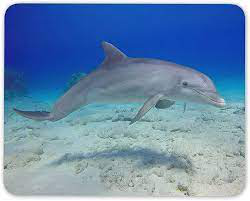

In [23]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[2])

In [25]:
import matplotlib.pyplot as plt
import cv2
cv2.imread(train_class.all_data[2])

array([[[250, 255, 247],
        [249, 255, 247],
        [249, 255, 247],
        ...,
        [255, 253, 255],
        [253, 254, 250],
        [251, 255, 249]],

       [[249, 255, 247],
        [249, 255, 247],
        [249, 255, 249],
        ...,
        [250, 247, 249],
        [251, 254, 252],
        [251, 255, 249]],

       [[249, 255, 247],
        [250, 255, 248],
        [250, 255, 250],
        ...,
        [252, 251, 255],
        [251, 254, 252],
        [249, 255, 250]],

       ...,

       [[255, 255, 255],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [254, 254, 254],
        [252, 252, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

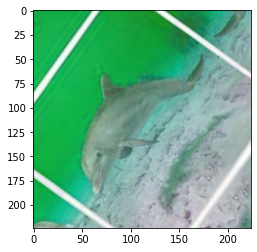

In [29]:
image = train_class[2][0].permute(1, 2, 0).numpy()
# unnormalize
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

plt.imshow((((image * std)+mean)*255).astype(int))

Hint
>1. 채널축을 바꿔야 함.
>2. mean, std값으로 거친 정규화를 unnormalize시켜주어야함.
>3. 픽셀 값을 다시 0~ 255 범위로 바꿔야함.
>4. numpy형태로 바꿔야함

## 직접 짠 코드.

In [47]:
import numpy as np

mean = np.mean(train_class[0][0].numpy())
std = np.std(train_class[0][0].numpy())

def converter(augmentationed_image):
  converted_image = augmentationed_image.permute(1, 2, 0)
  converted_image = (converted_image - mean) / std           # -> normalize : (converted_image - mean) / std   unnormalize : (augmentationed_image * std) + mean         실수한 부분.
  converted_image = converted_image.clip(0, 1)

  return converted_image

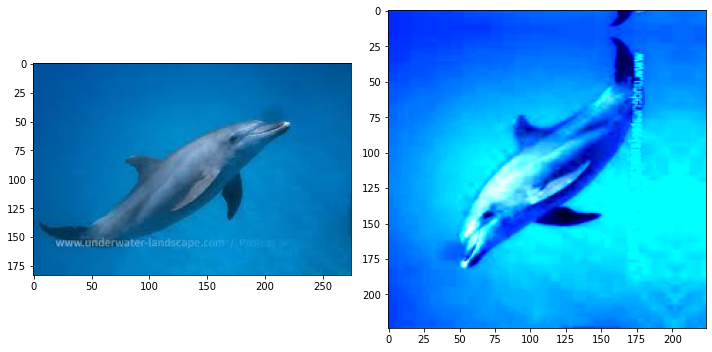

In [50]:
import matplotlib.pyplot as plt
converted_image = converter(train_class[0][0])

plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1) 
raw_image = plt.imread(train_class.all_data[0])
plt.imshow(raw_image)

plt.subplot(1, 2, 2) 
plt.imshow(converted_image)

plt.tight_layout()

## Solution 코드.

In [30]:
def converter(augmentationed_image):
  mean=(0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)
  
  ### 역함수 로직을 짜주세요. ###
  augmentationed_image = augmentationed_image.permute(1,2,0) # 채널축 정상적으로 맨뒤로 보내기
  augmentationed_image = augmentationed_image.numpy() # numpy 타입으로 변환
  augmentationed_image = (augmentationed_image * std) + mean # unnormalize
  converted_image = augmentationed_image * 255
  converted_image = converted_image.astype(int)

  return converted_image

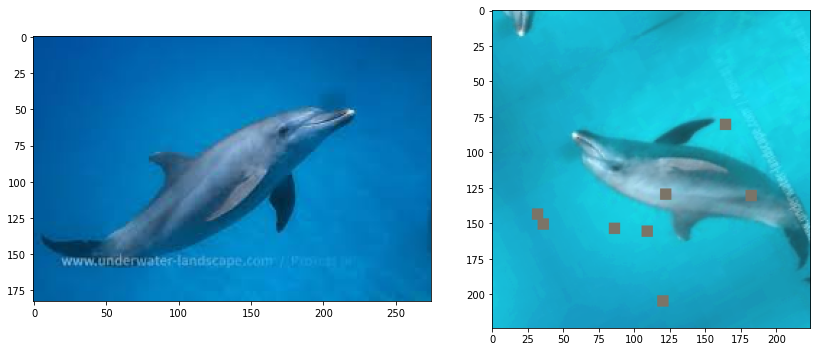

In [32]:
import matplotlib.pyplot as plt
converted_image = converter(train_class[0][0])

plt.figure(figsize = (12,5))

plt.subplot(1, 2, 1) 
raw_image = plt.imread(train_class.all_data[0])
plt.imshow(raw_image)

plt.subplot(1, 2, 2) 
plt.imshow(converted_image)

plt.tight_layout()